Issues: When setting up self, 2 errors are common:
1. RuntimeWarning: Mean of empty slice
2. ErrLinAlg, Linear matrix
This appears to cause the zphot to be overwhelmingly 11.87, which is the maximum value

In [1]:
%matplotlib inline

import eazy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier as v
import astropy.coordinates as coords
import astropy.units as u
import warnings
import os
from astropy.utils.exceptions import AstropyWarning
import h5py
import eazy.hdf5

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

Loading the ZFOURGE catalogue locally and running it through EAZY

In [2]:
# Loading ZFOURGE catalogue from local drive

os.getcwd()
field = 'cosmos' #'cdfs', 'cosmos', or 'uds'

# following files should be in the same dir as the project
param_file = f'{field}.param'
translate_file = f'{field}.translate'

self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file, zeropoint_file=None,
                         load_prior=True, load_products=False)

Read default param file: cosmos.param
Read CATALOG_FILE: zfourge/cosmos/cosmos.v1.3.8.cat
   >>> NOBJ = 20786
f_IRAC_80 e_IRAC_80 ( 21): IRAC/irac_tr4_2004-08-09.dat
f_IRAC_58 e_IRAC_58 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC_45 e_IRAC_45 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC_36 e_IRAC_36 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_Ks e_Ks (255): FOURSTAR/Ks_cam_optics_sky.txt
f_J1 e_J1 (249): FOURSTAR/J1_cam_optics_sky.txt
f_J2 e_J2 (250): FOURSTAR/J2_cam_optics_sky.txt
f_J3 e_J3 (251): FOURSTAR/J3_cam_optics_sky.txt
f_Hs e_Hs (254): FOURSTAR/Hshort_cam_optics_sky.txt
f_Hl e_Hl (253): FOURSTAR/Hlong_cam_optics_sky.txt
f_Zp e_Zp ( 83): COSMOS/SUBARU_filter_z.txt
f_Z e_Z ( 92): megaprime/cfht_mega_z_cfh9801.dat
f_I e_I ( 91): megaprime/cfht_mega_i_cfh9701.dat
f_Rp e_Rp ( 81): COSMOS/SUBARU_filter_r.txt
f_R e_R ( 90): megaprime/cfht_mega_r_cfh9601.dat
f_G e_G ( 89): megaprime/cfht_mega_g_cfh9401.dat
f_V e_V ( 79): COSMOS/SUBARU_filter_V.txt
f_B e_B ( 78): COSMOS/SUBARU_filter_B.txt
f_U

100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Template   7: c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat (NZ=1).
Template   8: erb2010_highEW.dat (NZ=1).
Process templates: 9.814 s


22it [00:00, 52.49it/s]


Iteration:  0


100%|██████████| 22/22 [00:45<00:00,  2.08s/it]


Compute best fits
fit_best: 0.4 s (n_proc=1,  NOBJ=430)
Fit 46.4 s (n_proc=8, NOBJ=20719)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Iteration:  1


100%|██████████| 22/22 [00:48<00:00,  2.20s/it]


Compute best fits
fit_best: 0.4 s (n_proc=1,  NOBJ=441)
Fit 49.0 s (n_proc=8, NOBJ=20719)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Iteration:  2


100%|██████████| 22/22 [00:53<00:00,  2.43s/it]


Compute best fits
fit_best: 0.5 s (n_proc=1,  NOBJ=439)
Fit 54.1 s (n_proc=8, NOBJ=20719)
Iterative correction - zeropoint / template


C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\eddie\anaconda3\envs\SEDTemplate_conda\lib\site-packages\numpy\core\fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


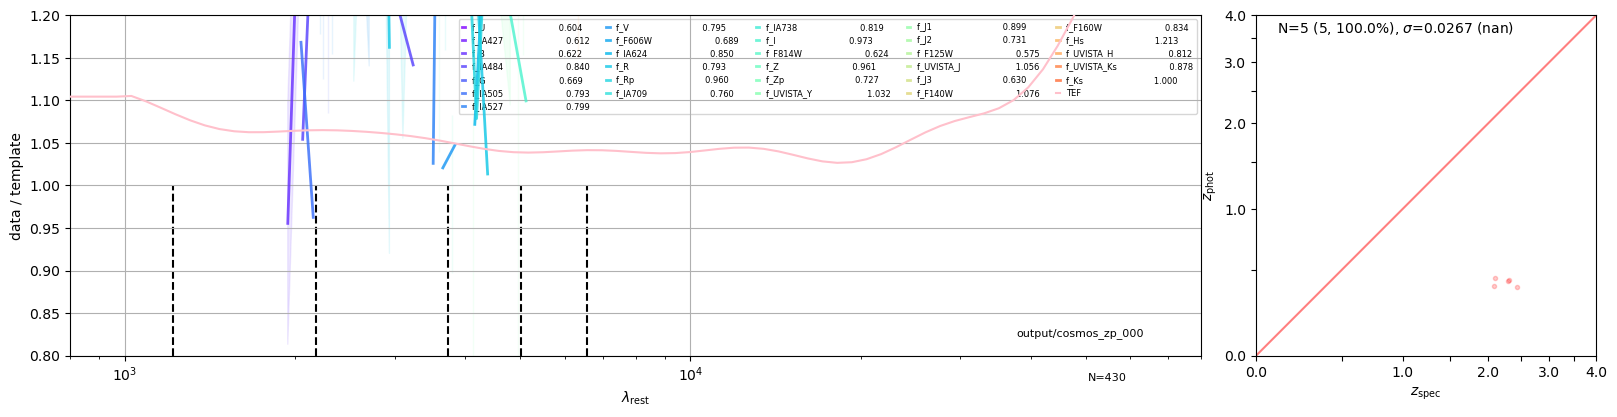

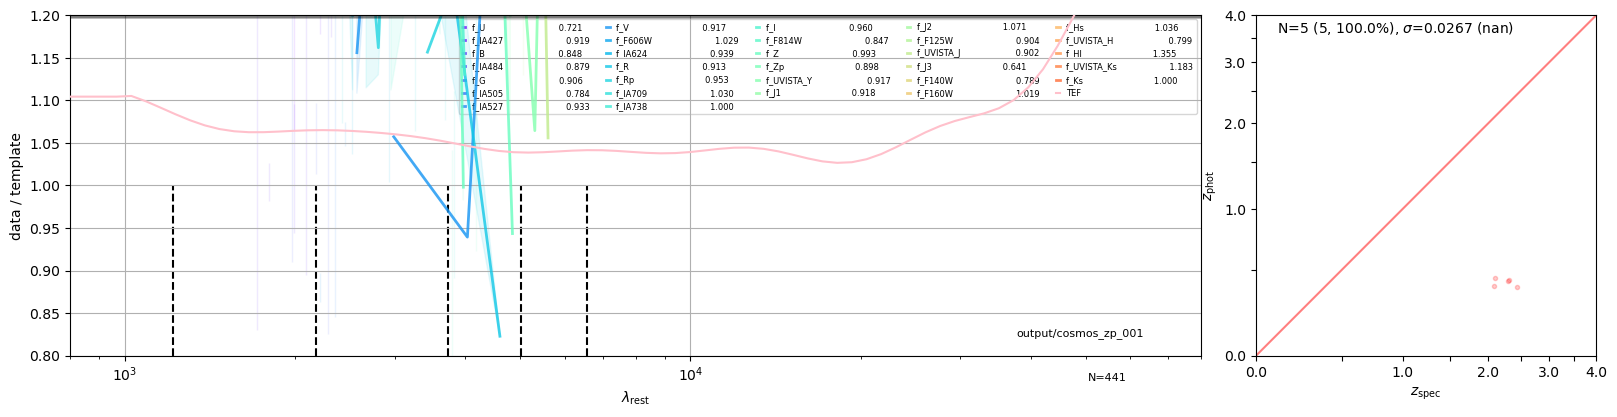

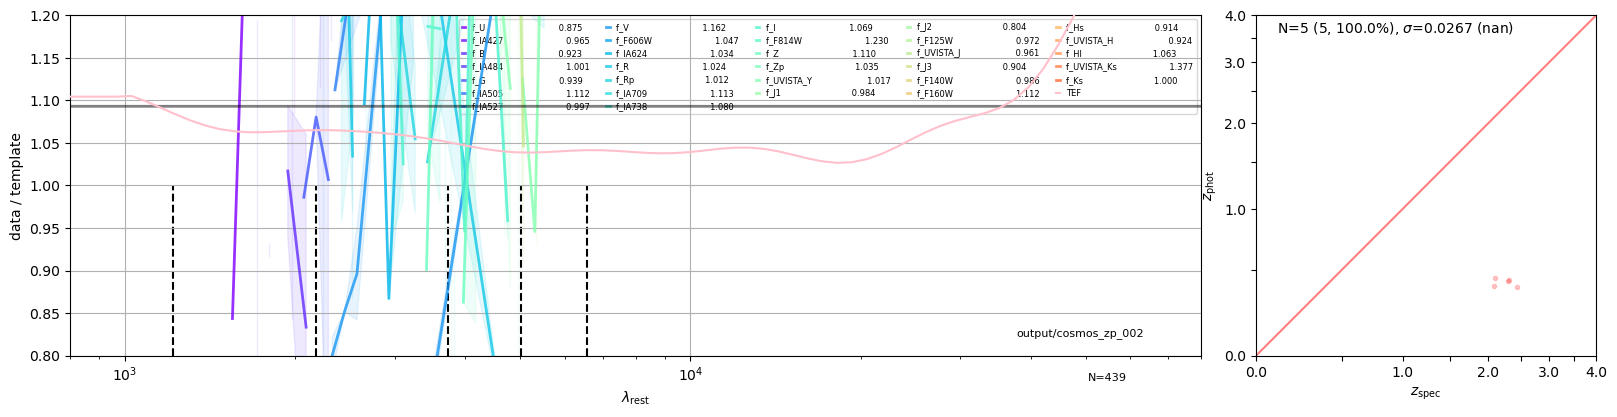

In [3]:
# Iterative Zero-point corrections

NITER = 3 # no. of iterations
NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

for iter in range(NITER):
    print('Iteration: ', iter)

    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                              update_zeropoints=True, iter=iter, n_proc=8,
                              save_templates=False, error_residuals=False,
                              NBIN=NBIN, get_spatial_offset=False)

Set sys_err = 0.03 (positive=True)


100%|██████████| 22/22 [00:48<00:00,  2.20s/it]


Compute best fits
fit_best: 0.4 s (n_proc=1,  NOBJ=318)
Fit 49.0 s (n_proc=8, NOBJ=20786)


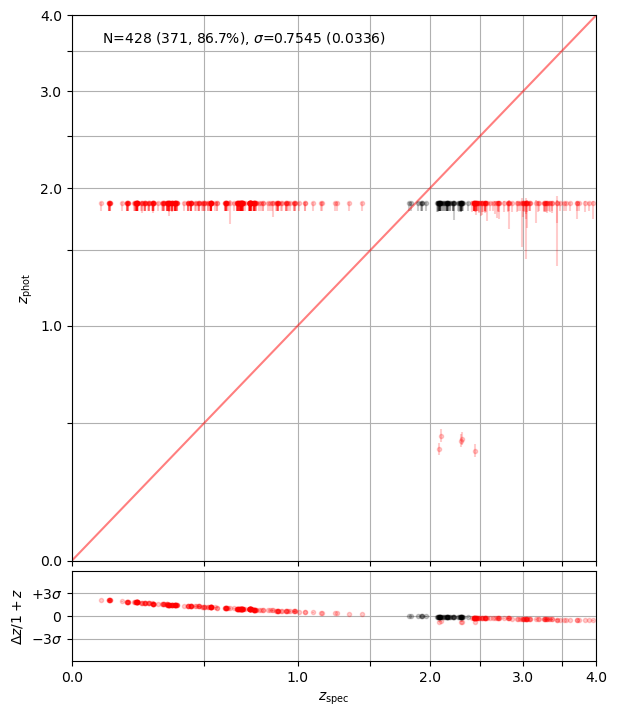

In [4]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

# Show zspec-zphot comparison
fig = self.zphot_zspec()

In [5]:
 # Derived parameters (z params, RF colors, masses, SFR, etc.)
warnings.simplefilter('ignore', category=RuntimeWarning)
zout, hdu = self.standard_output(simple=False,
                                 rf_pad_width=0.5, rf_max_err=2,
                                 prior=True, beta_prior=True,
                                 absmag_filters=[],
                                 extra_rf_filters=[])
# zout is also saved to the designated zout file in the parameter file

Get best fit coeffs & best redshifts
fit_best: 0.1 s (n_proc=1,  NOBJ=152)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 152/152 [00:01<00:00, 106.05it/s]



 Couldn't find template parameters file templates/eazy_v1.3.spectra.param.fits for population synthesis 
 calculations.
            


Text(0, 0.5, '$(U-V)_0$')

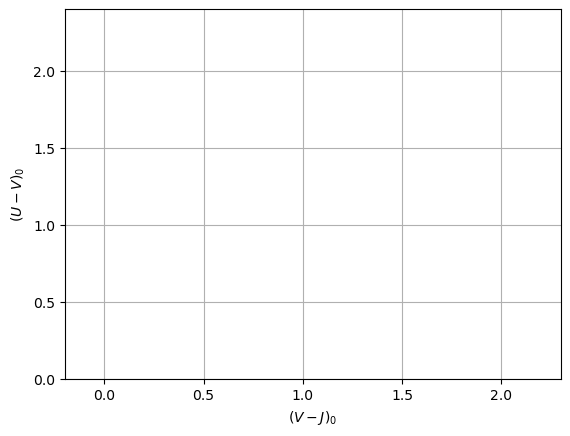

In [6]:
# Show UVJ diagram
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])
ssfr = zout['sfr']/zout['mass']

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel],
            vmin=-13, vmax=-8, alpha=0.5, cmap='RdYlBu')

plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')

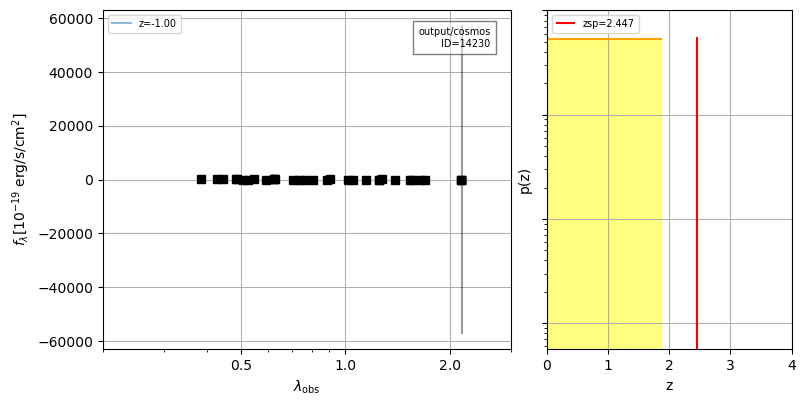

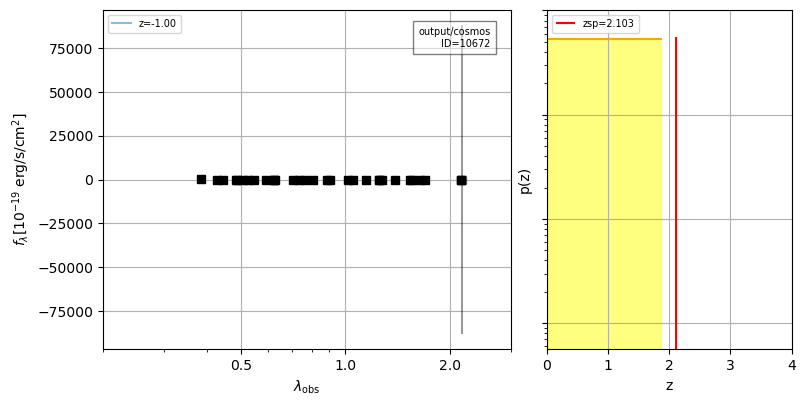

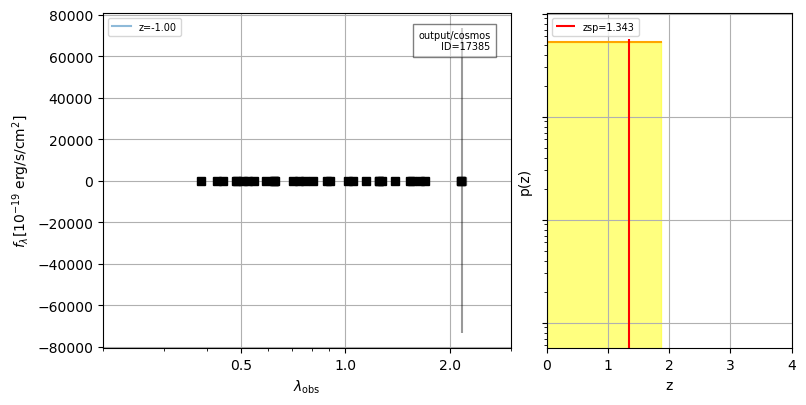

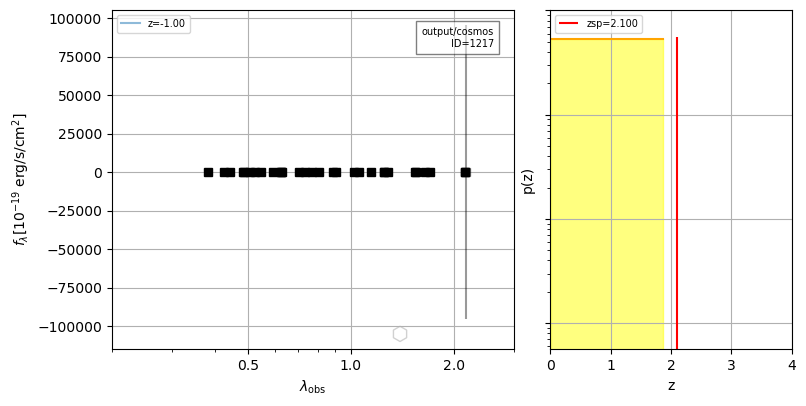

In [7]:
# Show brightest objects with z_spec > 1

ifilter = self.flux_columns[np.argmin((self.lc - 8140)**2)]

imag = 25 - 2.5*np.log10(self.cat[ifilter])
sel = (self.ZSPEC > 1.1)

so = np.argsort(imag[sel])
ids = self.OBJID[sel][so]

for i in range(4):
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3], show_components=True,
                              logpz=True, zr=[0,4])

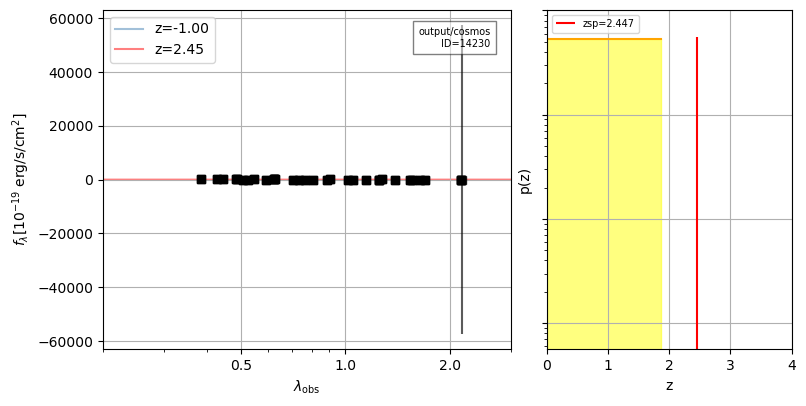

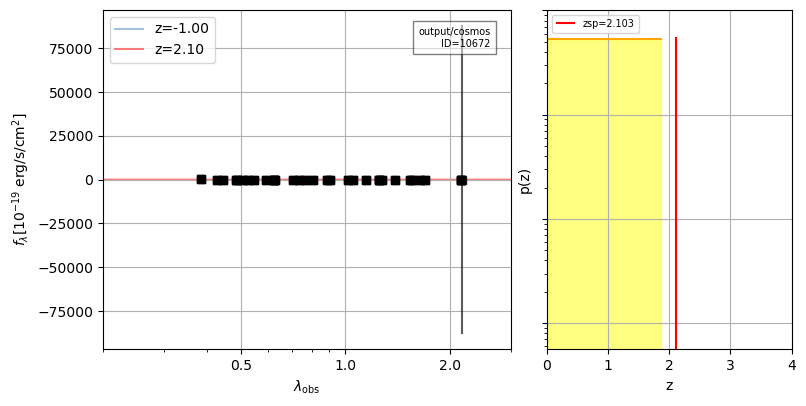

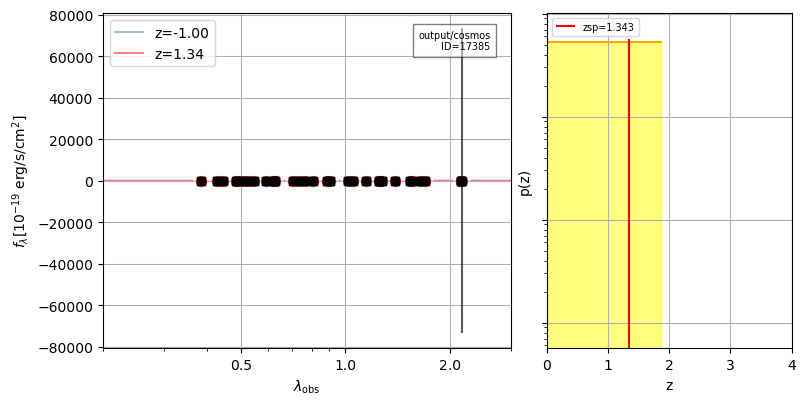

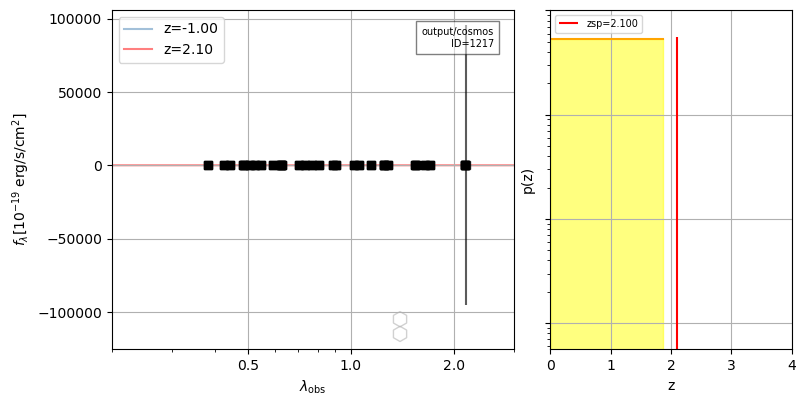

In [8]:
# Compare forced fit at z_spec
for i in range(4):
    ix = np.where(self.OBJID == ids[i])[0][0]
    fig, data = self.show_fit(ids[i], xlim=[0.2, 3],
                        show_components=False,
                        template_color='steelblue', logpz=True, zr=[0,4])

    # Now show with z_spec
    axes = fig.axes[:1]
    res = self.show_fit(ids[i], xlim=[0.2, 3], axes=axes,
                        zshow=self.ZSPEC[ix],
                        show_components=False,
                        template_color='r')

    axes[0].legend(loc='upper left')

In [9]:
zout.meta

OrderedDict([('version', ('0.6.8', 'Eazy-py version')),
             ('prior', (True, 'Prior applied (templates/prior_K_TAO.dat)')),
             ('betprior', (True, 'Beta prior applied')),
             ('fitter', ('nnls', 'Optimization method for template fits')),
             ('SYS_ERR', 0.03),
             ('TEMP_ERR_FILE', 'templates/TEMPLATE_ERROR.v2.0.zfourge'),
             ('TEMP_ERR_A2', 1.0),
             ('PRIOR_FILTER', 255.0),
             ('PRIOR_ABZP', 25.0),
             ('IGM_SCALE_TAU', 1.0),
             ('APPLY_IGM', 'y'),
             ('TEMPLATES_FILE', 'templates/eazy_v1.3.spectra.param'),
             ('TEMPL000', 'eazy_v1.1_sed1.dat'),
             ('TEMPL001', 'eazy_v1.1_sed2.dat'),
             ('TEMPL002', 'eazy_v1.1_sed3.dat'),
             ('TEMPL003', 'eazy_v1.1_sed4.dat'),
             ('TEMPL004', 'eazy_v1.1_sed5.dat'),
             ('TEMPL005', 'eazy_v1.1_sed6.dat'),
             ('TEMPL006', 'eazy_v1.1_sed7.dat'),
             ('TEMPL007', 'c09_del_8.6

In [10]:
zout.info()

<Table length=20786>
    name      dtype  shape       unit       format        description         n_bad
------------ ------- ----- ---------------- ------ -------------------------- -----
          id   int32                                                              0
          ra float64                                                              0
         dec float64                                                              0
      z_spec float64                                                              0
    nusefilt   int32                                                              0
        z_ml float32                                                              0
   z_ml_chi2 float32                                                              0
   z_ml_risk float32                                                              0
      lc_min float64                           .1f                                0
      lc_max float64                           .1f     

In [11]:
eazy.hdf5.write_hdf5(self, h5file=self.param['MAIN_OUTPUT_FILE'] + '.h5')

h5: create file output/cosmos.h5
h5: cat/flux_columns
h5: cat/err_columns
h5: cat/f_numbers
h5: cat/fnu
h5: cat/efnu_orig
h5: cat/ok_data
h5: cat/zp
h5: cat/ext_corr
h5: cat/ext_redden
h5: cat/pivot
h5: fit/zml
h5: fit/zbest
h5: fit/chi2_fit
h5: fit/coeffs_best
h5: fit/fit_coeffs
h5: templates/eazy_v1.1_sed1.dat
h5: templates/eazy_v1.1_sed2.dat
h5: templates/eazy_v1.1_sed3.dat
h5: templates/eazy_v1.1_sed4.dat
h5: templates/eazy_v1.1_sed5.dat
h5: templates/eazy_v1.1_sed6.dat
h5: templates/eazy_v1.1_sed7.dat
h5: templates/c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat
h5: templates/erb2010_highEW.dat
